# AHP Advanced Modeling
**Preprocess**
- Split 80% train and 20% test
- I drop 4 features with missing values more than 80%
- I use pipeline to preprocess the data, **won't include feature engineering** (I'm so bad at it), impute missing value using new class (None) for categorical data and median value for numeric data
- Yeah, I guess I did overlook for categorical data encoded in int64 data types, but for now, let them be (there's not much difference since not many variables have missing values)
- I **won't** scale numeric features, it's kinda useless for tree models anyway.  
- I use OrdinalEncoder for categorical data (better than one hot, less demanding in complexity)

**Modeling**
- Only focus on tree models
- I use 5-fold cross validation for evaluating the model
- For evaluation metrics, I use MSLE (root mean squared log error) as a main metric (needless to make it from scratch, it worked well already), and RMSE (root mean squared error) as a helper metric to understand the model better
- I guess that's all for today's briefing.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# models
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# selection & preprocess
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
# from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_log_error, root_mean_squared_error

# save
import joblib

In [2]:
df = pd.read_csv('../data/train.csv')
df.drop(columns=['Id'], inplace=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Splitting & Preprocess

In [3]:
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

# remove high missing cols
X.drop('PoolQC MiscFeature Alley Fence'.split(), axis=1, errors='ignore')

num_var = X.select_dtypes(include='number').columns
ord_var = X.select_dtypes(include='object').columns

# splitting data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.2, random_state = 42)
display(X_tr, X_te)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
254,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1066,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
638,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal
799,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal
380,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1130,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal
1294,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
860,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal
1105,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
413,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,3,2010,WD,Normal
522,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,10,2006,WD,Normal
1036,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca
1361,20,RL,124.0,16158,Pave,NaN,IR1,Low,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
802,60,RL,63.0,8199,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,10,2008,WD,Normal
651,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal


In [4]:
# Preprocess for numerical, ordinal, and nominal features
# Well, not really tho. 
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())
])
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

nom_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', num_pipe, num_var),
    ('ord', ord_pipe, ord_var)
])

## Modeling
4 tree models. Another way to do some modeling. 

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'rf': RandomForestRegressor(random_state=42),
    'hg': HistGradientBoostingRegressor(random_state=42),
    'xg': XGBRegressor(random_state=42),
    'lg': LGBMRegressor(random_state=42)
}


In [6]:
param_grids = {
    'rf':{
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 3, 5],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2']
    },

    'hg':{
        'model__max_iter': [50, 100, 200],
        'model__max_depth': [None, 3, 5],
        'model__learning_rate': [0.01, 0.1],
        'model__max_leaf_nodes': [15, 31, 63],
        'model__l2_regularization': [0.0, 1.0]
    },

    'xg':{
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, None],
        'model__learning_rate': [0.05, 0.1],
        'model__subsample': [0.7, None]
    },
    
    'lg':{        
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.05, 0.1],
        'model__subsample': [0.7, None],
        'model__num_leaves': [31, 63]
    }
}

In [7]:
# 15 mins (gosh we shouldn't run it for several times.)
res03 = []

for name, model in models.items():
    grid = param_grids[name]
    
    full_pipe = Pipeline([
        # ('eng', feature_eng),
        ('pre', preprocess),
        ('model', model)
        ])
    
    search = GridSearchCV(
        full_pipe, grid, cv=kf, 
        scoring = {'rmse':'neg_root_mean_squared_error',
                   'msle':'neg_root_mean_squared_log_error'},
                   refit = 'msle', verbose=0, n_jobs=-1)
    search.fit(X_tr, y_tr)
    
    print(name)

    cv_res = pd.DataFrame(search.cv_results_)
    cv_res['rmse'] = -cv_res['mean_test_rmse']
    cv_res['msle'] = -cv_res['mean_test_msle']
    cv_res['time'] = cv_res['mean_fit_time']
    cv_res['model'] = name

    top3 = cv_res.sort_values('msle').head(3).copy()

    top3['rank'] = [1,2,3]
    top3['grid'] = search
    res03.append(top3[['model', 'rank', 'rmse', 'msle', 'time', 'params', 'grid']])


rf
hg
xg
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3126
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 73
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [8]:
# combine all
all_res03 = pd.concat(res03, ignore_index=True).sort_values('msle', ascending=True)

# take a look at the params, and simplify for the next models or so? 
all_res03

,model,rank,rmse,msle,time,params,grid
6,xg,1,27289.708203,0.128372,0.343498,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
7,xg,2,27196.271484,0.128424,0.318693,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
8,xg,3,26982.405469,0.129729,0.357719,"{'model__learning_rate': 0.05, 'model__max_dep...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
9,lg,1,28260.994320,0.130902,0.255739,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
11,lg,3,28260.994320,0.130902,0.258501,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
10,lg,2,28260.994320,0.130902,0.262644,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
3,hg,1,28184.050743,0.131116,0.436537,"{'model__l2_regularization': 1.0, 'model__lear...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
5,hg,3,28184.050743,0.131116,0.425116,"{'model__l2_regularization': 1.0, 'model__lear...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
4,hg,2,28184.050743,0.131116,0.430311,"{'model__l2_regularization': 1.0, 'model__lear...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
0,rf,1,29951.687935,0.145708,1.233245,"{'model__max_depth': None, 'model__max_feature...","GridSearchCV(cv=KFold(n_splits=5, random_state..."


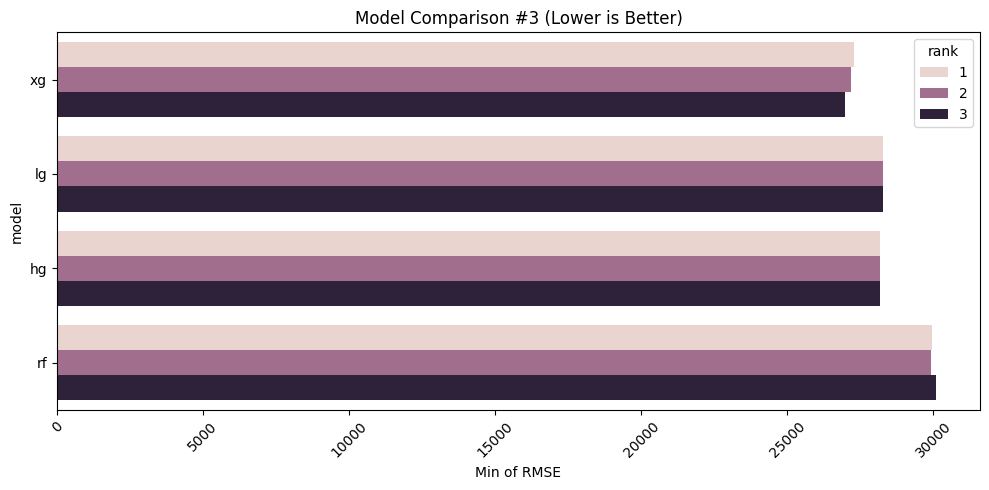

In [9]:
# Plot RMSE Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=all_res03, y='model', x='rmse', estimator='min', orient='h', errorbar=None, hue='rank')
plt.xticks(rotation=45)
# plt.axvline(x=28713) # checking whether estimator min really works. 
plt.xlabel('Min of RMSE')
plt.title('Model Comparison #3 (Lower is Better)')
plt.tight_layout()
plt.savefig('../outputs/model_comparison3.png')
plt.show()

In [10]:
# # save, can't do with feature_eng, need to be in py or so? 
joblib.dump(all_res03.loc[1, 'grid'].best_estimator_, '../models/best_tuned01.joblib')

['../models/best_tuned01.joblib']

In [11]:
# Predict & evaluate on test set
y_pred = all_res03.loc[1, 'grid'].predict(X_te)
rmse = root_mean_squared_error(y_te, y_pred)
msle = root_mean_squared_log_error(y_te, y_pred)
print("Test RMSE:", round(rmse, -3), "\nTest MSLE", round(msle,3)), rmse/163

Test RMSE: 31000.0 
Test MSLE 0.164


(None, 191.6463487589148)

In [24]:
## check for params
list(all_res03.loc[all_res03.model=='rf', 'params']) # None, sqrt, 1, 2/5, 100/200
list(all_res03.loc[all_res03.model=='hg', 'params']) # 1, 0.1, 3, 15/31/63 no diff. oh lg and hg are kinda the same for all?
list(all_res03.loc[all_res03.model=='xg', 'params']) # 1, 0.1, 3, 15/31/63 no diff. oh lg and hg are kinda the same for all?


[{'model__learning_rate': 0.1,
  'model__max_depth': 3,
  'model__n_estimators': 200,
  'model__subsample': 0.7},
 {'model__learning_rate': 0.1,
  'model__max_depth': 3,
  'model__n_estimators': 200,
  'model__subsample': None},
 {'model__learning_rate': 0.05,
  'model__max_depth': 3,
  'model__n_estimators': 200,
  'model__subsample': 0.7}]

## Feature Selection (MI)
Only use some features based on mutual information: the first 20 (minus GarageYrBlt cuz of its high correlation with YearBuilt). 


In [21]:
select_feature = ['OverallQual', 'Neighborhood', 'GarageArea', 'GrLivArea', 'YearBuilt',
               'TotalBsmtSF', 'LotArea', 'GarageCars', 'ExterQual', 'KitchenQual',
               'BsmtQual', '1stFlrSF', 'MSSubClass', 'YearRemodAdd',
               'GarageFinish', 'FullBath', 'TotRmsAbvGrd', 'GarageType', 'FireplaceQu']

# redefine the cols. 
num_cols = X.select_dtypes(include='number').columns
num_cols = [i for i in num_cols if i in select_feature]

cat_cols = X.select_dtypes(include='object').columns
cat_cols = [i for i in cat_cols if i in select_feature]

# the rest are just the same. 
X1_tr = X_tr.copy()
y1_tr = y_tr.copy()

# kf and models are the same as above. 

In [22]:
# Preprocess for numerical, ordinal, and nominal features
# num the same, just redefine it so easier to see. 
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

pre1 = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('ord', cat_pipe, cat_cols)
])


In [25]:
params1 = {
    'rf':{
        'model__n_estimators': [100, 200],
        # 'model__max_depth': [None, 3, 5],
        'model__min_samples_split': [2, 5],
        # 'model__min_samples_leaf': [1, 2],
        # 'model__max_features': ['sqrt', 'log2']
    },

    'hg':{
        'model__max_iter': [200, 500],
        'model__max_depth': [None, 3],
        'model__learning_rate': [0.05, 0.1],
        # 'model__max_leaf_nodes': [15, 31, 63],
        # 'model__l2_regularization': [0.0, 1.0]
    },

    'xg':{
        'model__n_estimators': [200, 500],
        'model__max_depth': [3, 7],
        'model__learning_rate': [0.05, 0.1],
        'model__subsample': [0.7, None]
    },
    
    'lg':{        
        'model__n_estimators': [200, 500],
        'model__max_depth': [3, None],
        # 'model__learning_rate': [0.1],
        'model__subsample': [0.7, None],
        # 'model__num_leaves': [31, 63]
    }
}

In [26]:
# 15 mins (gosh we shouldn't run it for several times.)
# should've make a function of it lol.
res04 = []

for name, model in models.items():
    grid1 = params1[name]
    
    pipe1 = Pipeline([
        ('pre', pre1), ('model', model)
        ])
    
    search1 = GridSearchCV(
        pipe1, grid1, cv=kf, 
        scoring = {'rmse':'neg_root_mean_squared_error',
                   'msle':'neg_root_mean_squared_log_error'},
                   refit = 'msle', verbose=0, n_jobs=-1)
    search1.fit(X1_tr, y1_tr)
    
    print(name)

    cv_res1 = pd.DataFrame(search1.cv_results_)
    cv_res1['rmse'] = -cv_res1['mean_test_rmse']
    cv_res1['msle'] = -cv_res1['mean_test_msle']
    cv_res1['time'] = cv_res1['mean_fit_time']
    cv_res1['model'] = name

    top1 = cv_res1.sort_values('msle').head(3).copy()

    top1['rank'] = [1, 2, 3]
    top1['grid'] = search1
    res04.append(top1[['model', 'rank', 'rmse', 'msle', 'time', 'params', 'grid']])

rf
hg
xg
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1528
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 19
[LightGBM] [Info] Start training from score 181441.541952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [27]:
# combine all
all_res04 = pd.concat(res04, ignore_index=True).sort_values('msle', ascending=True)

# take a look at the params, and simplify for the next models or so? 
all_res04

,model,rank,rmse,msle,time,params,grid
6,xg,1,29614.929297,0.145055,0.391832,"{'model__learning_rate': 0.05, 'model__max_dep...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
7,xg,2,29098.906250,0.146164,0.135151,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
3,hg,1,29510.157255,0.146621,0.991220,"{'model__learning_rate': 0.05, 'model__max_dep...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
9,lg,1,29715.802698,0.146868,0.282905,"{'model__max_depth': 3, 'model__n_estimators':...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
10,lg,2,29715.802698,0.146868,0.351695,"{'model__max_depth': 3, 'model__n_estimators':...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
8,xg,3,29390.348438,0.147148,0.319659,"{'model__learning_rate': 0.05, 'model__max_dep...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
4,hg,2,29800.490986,0.147571,0.191865,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
11,lg,3,29853.309790,0.147848,0.425121,"{'model__max_depth': 3, 'model__n_estimators':...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
5,hg,3,29953.428625,0.148019,0.558532,"{'model__learning_rate': 0.1, 'model__max_dept...","GridSearchCV(cv=KFold(n_splits=5, random_state..."
0,rf,1,31178.988706,0.156121,2.833094,"{'model__min_samples_split': 5, 'model__n_esti...","GridSearchCV(cv=KFold(n_splits=5, random_state..."


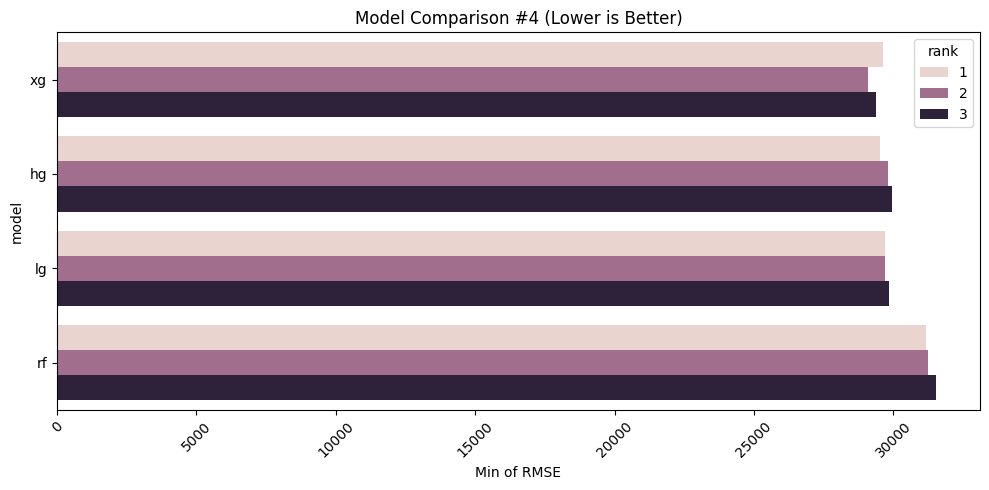

In [28]:
# Plot RMSE Comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=all_res04, y='model', x='rmse', estimator='min', orient='h', errorbar=None, hue='rank')
plt.xticks(rotation=45)
# plt.axvline(x=28713) # checking whether estimator min really works. 
plt.xlabel('Min of RMSE')
plt.title('Model Comparison #4 (Lower is Better)')
plt.tight_layout()
plt.savefig('../outputs/model_comparison4.png')
plt.show()

In [29]:
# # save, can't do with feature_eng, need to be in py or so? 
joblib.dump(all_res04.loc[1, 'grid'].best_estimator_, '../models/best_select.joblib')

['../models/best_select.joblib']

In [30]:
# Predict & evaluate on test set
y_pred = all_res04.loc[1, 'grid'].predict(X_te)
rmse = root_mean_squared_error(y_te, y_pred)
msle = root_mean_squared_log_error(y_te, y_pred)
print("Test RMSE:", round(rmse, -3), "\nTest MSLE", round(msle,3)), rmse/163

Test RMSE: 30000.0 
Test MSLE 0.163


(None, 183.51494402937874)